In [1]:
# Импорт библиотек
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path

# Наши модули
from src.models.multiclass_classifier import MulticlassTrafficClassifier, compare_multiclass_models

print("Запуск многоклассовой классификации")

# Загрузка подготовленных данных
print("Загрузка данных...")
X_normalized = pd.read_parquet('../data/processed/X_normalized.parquet')

# Загрузка многоклассовых меток
print("Загрузка меток типов атак...")
try:
    y_multiclass = pd.read_parquet('../data/processed/y_multiclass.parquet')['attack_cat']
    print(f"Многоклассовые метки загружены: {y_multiclass.shape}")
except FileNotFoundError:
    print("Файл с многоклассовыми метками не найден")
    print("Загружаем из исходных данных...")
    # Альтернативная загрузка если файла нет
    from src.data.loader import load_unsw_nb15_parquet
    df_original = load_unsw_nb15_parquet('../data/raw')
    y_multiclass = df_original['attack_cat']
    # Сохраняем для будущего использования
    y_multiclass.to_frame().to_parquet('../data/processed/y_multiclass.parquet')

print(f"Признаки: {X_normalized.shape}")
print(f"Метки типов атак: {y_multiclass.shape}")
print(f"Распределение типов атак:")
print(y_multiclass.value_counts())

Запуск многоклассовой классификации
Загрузка данных...
Загрузка меток типов атак...
Многоклассовые метки загружены: (257673,)
Признаки: (257673, 49)
Метки типов атак: (257673,)
Распределение типов атак:
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64



Анализ распределения типов атак


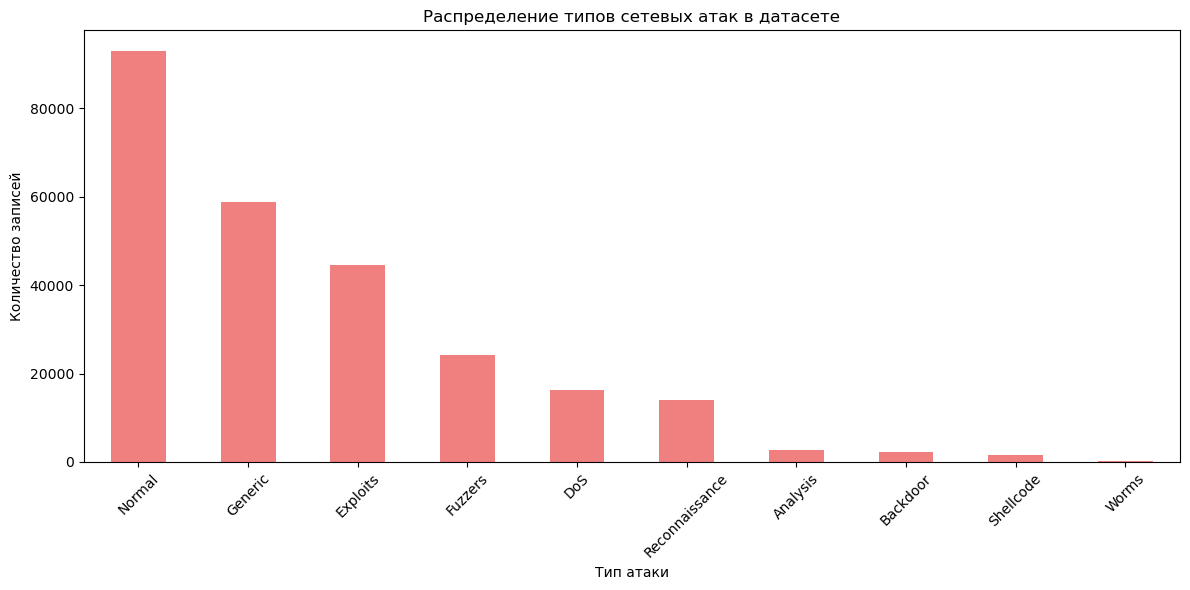

Статистика распределения:
Всего типов атак: 10
Самый частый тип: Normal (93000 записей)
Самый редкий тип: Worms (174 записей)
Дисбаланс: 534.5 раз


In [2]:
# Анализ распределения типов атак
print("\nАнализ распределения типов атак")

# Визуализация распределения
plt.figure(figsize=(12, 6))
attack_counts = y_multiclass.value_counts()
attack_counts.plot(kind='bar', color='lightcoral')
plt.title('Распределение типов сетевых атак в датасете')
plt.xlabel('Тип атаки')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/multiclass_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Статистика распределения:")
print(f"Всего типов атак: {len(attack_counts)}")
print(f"Самый частый тип: {attack_counts.index[0]} ({attack_counts.iloc[0]} записей)")
print(f"Самый редкий тип: {attack_counts.index[-1]} ({attack_counts.iloc[-1]} записей)")
print(f"Дисбаланс: {attack_counts.iloc[0] / attack_counts.iloc[-1]:.1f} раз")

In [3]:

# Инициализация классификатора
multiclass_classifier = MulticlassTrafficClassifier()

# Подготовка меток
y_encoded = multiclass_classifier.prepare_labels(y_multiclass)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_multiclass, 
    test_size=0.2, 
    random_state=42,
    stratify=y_multiclass  # важно сохранить распределение для многоклассовой
)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Типы атак в тренировочной: {y_train.value_counts().to_dict()}")
print(f"Типы атак в тестовой: {y_test.value_counts().to_dict()}")

# Инициализация моделей
multiclass_classifier.initialize_models()

Обнаружено типов атак: 10
Типы атак: ['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic']
Тренировочная выборка: (206138, 49)
Тестовая выборка: (51535, 49)
Типы атак в тренировочной: {'Normal': 74400, 'Generic': 47097, 'Exploits': 35620, 'Fuzzers': 19397, 'DoS': 13082, 'Reconnaissance': 11189, 'Analysis': 2142, 'Backdoor': 1863, 'Shellcode': 1209, 'Worms': 139}
Типы атак в тестовой: {'Normal': 18600, 'Generic': 11774, 'Exploits': 8905, 'Fuzzers': 4849, 'DoS': 3271, 'Reconnaissance': 2798, 'Analysis': 535, 'Backdoor': 466, 'Shellcode': 302, 'Worms': 35}
Многоклассовые модели инициализированы


{'RandomForest': RandomForestClassifier(class_weight='balanced', max_depth=15, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, ...),
 'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr',
  

In [4]:
# Кодируем метки для обучения
y_train_encoded = multiclass_classifier.label_encoder.transform(y_train)

# Обучение моделей
results = multiclass_classifier.train_models(X_train, y_train_encoded, X_test, y_test)


	Обучение RandomForest...
	RandomForest: Accuracy = 0.7395
	Подробный отчет сохранен

	Обучение XGBoost...
	XGBoost: Accuracy = 0.8200
	Подробный отчет сохранен

	Обучение LogisticRegression...


C:\Users\ro517\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


	LogisticRegression: Accuracy = 0.6280
	Подробный отчет сохранен

 Лучшая многоклассовая модель: XGBoost (Accuracy = 0.8200)



Детальная оценка лучшей модели

Анализ по классам: XGBoost

Отчет о классификации:
                precision    recall  f1-score   support

      Analysis       0.92      0.08      0.15       535
      Backdoor       0.92      0.10      0.18       466
           DoS       0.67      0.05      0.10      3271
      Exploits       0.61      0.92      0.74      8905
       Fuzzers       0.69      0.48      0.57      4849
       Generic       0.99      0.98      0.99     11774
        Normal       0.88      0.94      0.91     18600
Reconnaissance       0.92      0.78      0.84      2798
     Shellcode       0.51      0.57      0.54       302
         Worms       0.35      0.26      0.30        35

      accuracy                           0.82     51535
     macro avg       0.74      0.52      0.53     51535
  weighted avg       0.83      0.82      0.79     51535



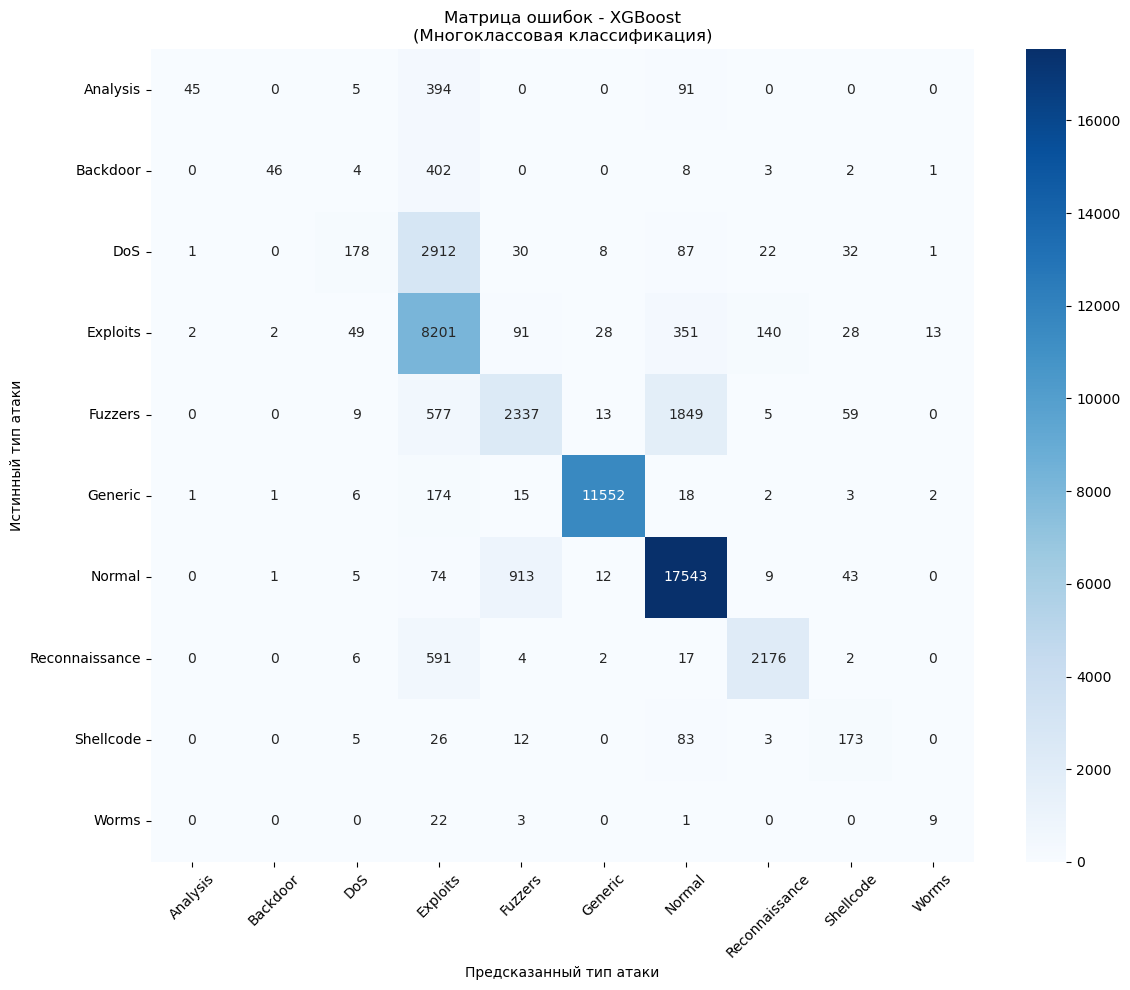


Анализ важности признаков

Топ-15 самых важных признаков для многоклассовой классификации:
                             feature  importance
37       remainder__cat__service_dns    0.448310
14              num__remainder__swin    0.164211
34         remainder__cat__proto_udp    0.052700
35        remainder__cat__proto_unas    0.045279
30         remainder__cat__proto_arp    0.036667
36         remainder__cat__service_-    0.022065
18            num__remainder__tcprtt    0.020976
7              num__remainder__dload    0.020604
32       remainder__cat__proto_other    0.019099
31        remainder__cat__proto_ospf    0.016296
6              num__remainder__sload    0.014623
21             num__remainder__smean    0.012995
4             num__remainder__dbytes    0.011140
39  remainder__cat__service_ftp-data    0.010879
22             num__remainder__dmean    0.010572


C:\Users\ro517\AppData\Local\Temp\ipykernel_13280\1152508515.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='magma')


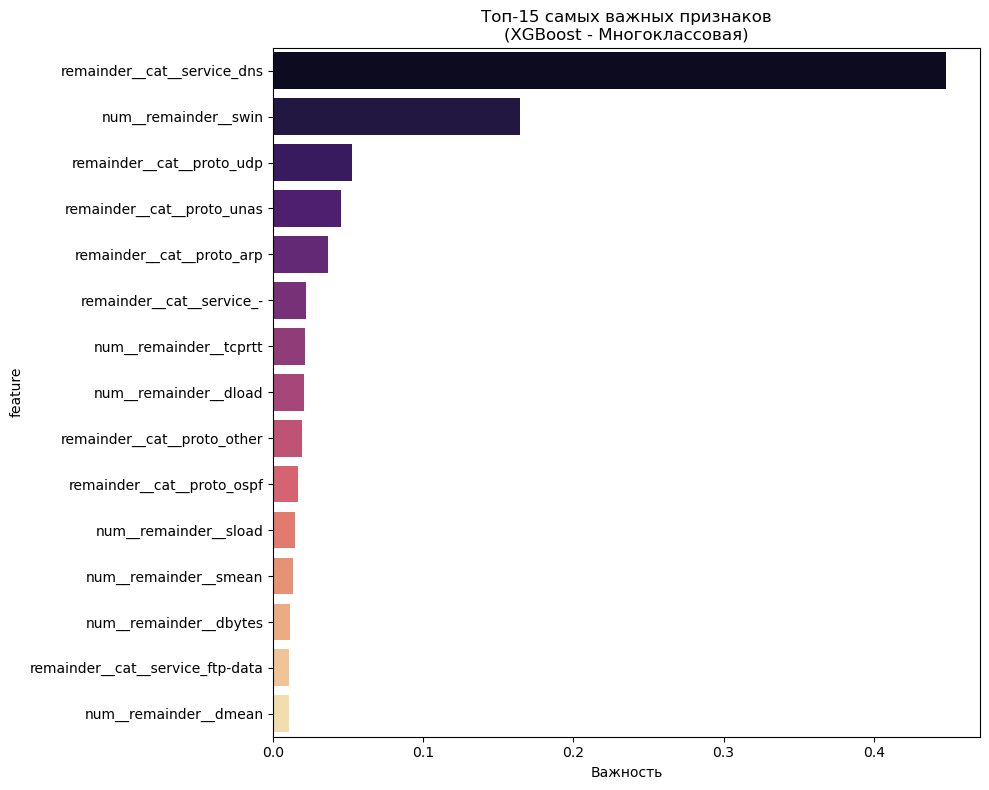

In [5]:
# Детальная оценка лучшей модели
print("\nДетальная оценка лучшей модели")

best_result = results[multiclass_classifier.best_model_name]
y_test_encoded = multiclass_classifier.label_encoder.transform(y_test)

# Анализ по классам
cm = multiclass_classifier.analyze_class_performance(
    y_test_encoded, 
    best_result['y_pred'], 
    multiclass_classifier.best_model_name
)

# Анализ важности признаков
print("\nАнализ важности признаков")
top_features = multiclass_classifier.get_feature_importance(X_normalized.columns, top_n=15)

if top_features is not None:
    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, x='importance', y='feature', palette='magma')
    plt.title(f'Топ-15 самых важных признаков\n({multiclass_classifier.best_model_name} - Многоклассовая)')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.savefig('../reports/figures/multiclass_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


Сравнение многоклассовых моделей:
                Model  Accuracy  Macro Precision  Macro Recall  Macro F1
1             XGBoost  0.820025         0.744829      0.517215  0.530728
0        RandomForest  0.739497         0.520366      0.640260  0.529420
2  LogisticRegression  0.628000         0.390649      0.526711  0.371812


C:\Users\ro517\Рабочий стол\Потуги развития\Проекты\network-traffic-analysis\notebooks\..\src\models\multiclass_classifier.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x=metric, y='Model', ax=ax, palette='viridis')
C:\Users\ro517\Рабочий стол\Потуги развития\Проекты\network-traffic-analysis\notebooks\..\src\models\multiclass_classifier.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x=metric, y='Model', ax=ax, palette='viridis')
C:\Users\ro517\Рабочий стол\Потуги развития\Проекты\network-traffic-analysis\notebooks\..\src\models\multiclass_classifier.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

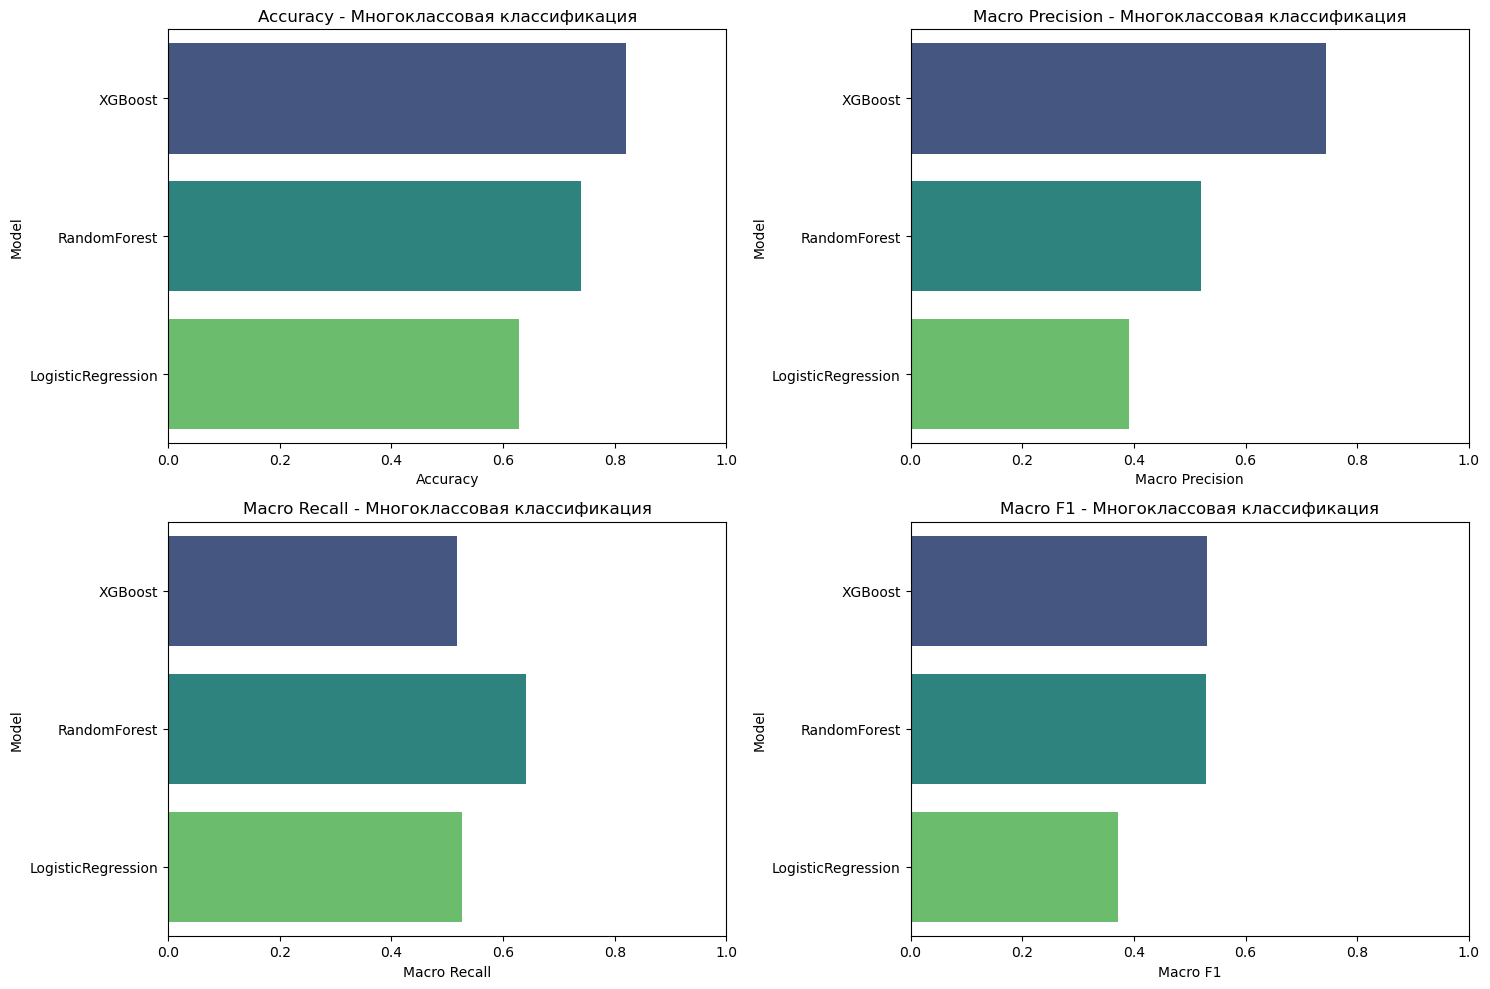

In [6]:
comparison_df = compare_multiclass_models(results)

# Сохраняем сравнение
comparison_df.to_csv('../reports/multiclass_model_comparison.csv', index=False)


Детальный анализ ошибок классификации
Всего ошибок: 9275 (18.00%)

Самые частые ошибки классификации:
              true       predicted  count
10             DoS        Exploits   2912
29         Fuzzers          Normal   1849
44          Normal         Fuzzers    913
49  Reconnaissance        Exploits    591
27         Fuzzers        Exploits    577
4         Backdoor        Exploits    402
1         Analysis        Exploits    394
22        Exploits          Normal    351
35         Generic        Exploits    174
23        Exploits  Reconnaissance    140


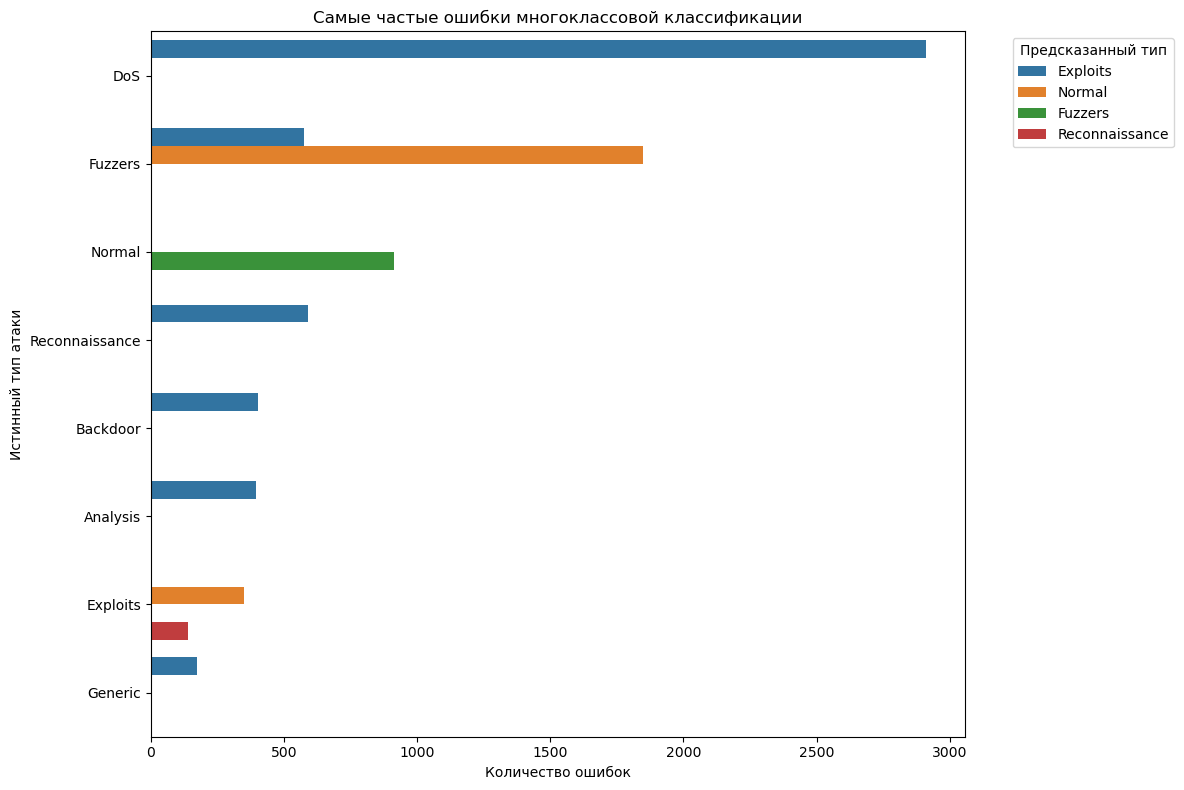

In [7]:
# Детальный анализ ошибок классификации
print("\nДетальный анализ ошибок классификации")

def analyze_classification_errors(y_true, y_pred, label_encoder, X_test_original):
    """Анализ наиболее частых ошибок классификации"""
    y_true_decoded = label_encoder.inverse_transform(y_true)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    errors = y_true_decoded != y_pred_decoded
    error_indices = np.where(errors)[0]
    
    print(f"Всего ошибок: {len(error_indices)} ({len(error_indices)/len(y_true)*100:.2f}%)")
    
    # Анализ самых частых неправильных предсказаний
    error_pairs = pd.DataFrame({
        'true': y_true_decoded[errors],
        'predicted': y_pred_decoded[errors]
    })
    
    common_errors = error_pairs.groupby(['true', 'predicted']).size().reset_index(name='count')
    common_errors = common_errors.sort_values('count', ascending=False)
    
    print("\nСамые частые ошибки классификации:")
    print(common_errors.head(10))
    
    return common_errors

# Запускаем анализ ошибок
common_errors = analyze_classification_errors(
    y_test_encoded, 
    best_result['y_pred'], 
    multiclass_classifier.label_encoder,
    X_test
)

# Визуализация частых ошибок
if len(common_errors) > 0:
    plt.figure(figsize=(12, 8))
    top_errors = common_errors.head(10)
    sns.barplot(data=top_errors, x='count', y='true', hue='predicted')
    plt.title('Самые частые ошибки многоклассовой классификации')
    plt.xlabel('Количество ошибок')
    plt.ylabel('Истинный тип атаки')
    plt.legend(title='Предсказанный тип', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('../reports/figures/multiclass_common_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# Сохранение результатов многоклассовой классификации

models_path = Path("../models")

reports_path = Path("../reports")
# Сохраняем лучшую модель
multiclass_classifier.save_best_model(models_path / "best_multiclass_classifier.joblib")

# Сохраняем сравнение моделей
comparison_df.to_csv(reports_path / "multiclass_model_comparison.csv", index=False)

# Сохраняем важность признаков если есть
if multiclass_classifier.feature_importance is not None:
    multiclass_classifier.feature_importance.to_csv(reports_path / "multiclass_feature_importance.csv", index=False)

# Сохраняем ключевые метрики
key_metrics = {
    'best_model': multiclass_classifier.best_model_name,
    'best_accuracy': float(results[multiclass_classifier.best_model_name]['accuracy']),
    'test_set_size': len(y_test),
    'number_of_attack_types': len(multiclass_classifier.attack_types),
    'attack_types': list(multiclass_classifier.attack_types),
    'all_models': {}
}

for name, result in results.items():
    key_metrics['all_models'][name] = {
        'accuracy': float(result['accuracy']),
        'macro_precision': float(result['classification_report']['macro avg']['precision']),
        'macro_recall': float(result['classification_report']['macro avg']['recall']),
        'macro_f1': float(result['classification_report']['macro avg']['f1-score'])
    }

import json
with open(reports_path / "multiclass_key_metrics.json", 'w') as f:
    json.dump(key_metrics, f, indent=2, ensure_ascii=False)

print("Все результаты многоклассовой классификации сохранены")

Лучшая многоклассовая модель сохранена: ..\models\best_multiclass_classifier.joblib
Все результаты многоклассовой классификации сохранены


In [9]:
report = f"""
ОТЧЕТ ПО МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ ТИПОВ АТАК
{'='*60}

ДАННЫЕ:
- Общее количество записей: {len(X_normalized)}
- Количество признаков: {X_normalized.shape[1]}
- Количество типов атак: {len(multiclass_classifier.attack_types)}
- Тренировочная выборка: {X_train.shape[0]} записей
- Тестовая выборка: {X_test.shape[0]} записей

ТИПЫ АТАК:
{list(multiclass_classifier.attack_types)}

РЕЗУЛЬТАТЫ:
- Лучшая модель: {multiclass_classifier.best_model_name}
- Accuracy лучшей модели: {results[multiclass_classifier.best_model_name]['accuracy']:.4f}

СРАВНЕНИЕ МОДЕЛЕЙ:
"""

for name, result in results.items():
    report += f"- {name}: Accuracy = {result['accuracy']:.4f}\n"

report += f"""
СОХРАНЕННЫЕ ФАЙЛЫ:
1. models/best_multiclass_classifier.joblib - лучшая модель + label encoder
2. reports/multiclass_model_comparison.csv - сравнение моделей  
3. reports/multiclass_key_metrics.json - детальные метрики
4. reports/figures/ - визуализации

ВЫВОД:
Многоклассовая классификация завершена успешно! Модель готова к определению конкретных типов сетевых атак.
"""

print(report)

# Сохраняем отчет
with open(reports_path / "multiclass_classification_report.txt", "w", encoding='utf-8') as f:
    f.write(report)


ОТЧЕТ ПО МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ ТИПОВ АТАК

ДАННЫЕ:
- Общее количество записей: 257673
- Количество признаков: 49
- Количество типов атак: 10
- Тренировочная выборка: 206138 записей
- Тестовая выборка: 51535 записей

ТИПЫ АТАК:
['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic']

РЕЗУЛЬТАТЫ:
- Лучшая модель: XGBoost
- Accuracy лучшей модели: 0.8200

СРАВНЕНИЕ МОДЕЛЕЙ:
- RandomForest: Accuracy = 0.7395
- XGBoost: Accuracy = 0.8200
- LogisticRegression: Accuracy = 0.6280

СОХРАНЕННЫЕ ФАЙЛЫ:
1. models/best_multiclass_classifier.joblib - лучшая модель + label encoder
2. reports/multiclass_model_comparison.csv - сравнение моделей  
3. reports/multiclass_key_metrics.json - детальные метрики
4. reports/figures/ - визуализации

ВЫВОД:
Многоклассовая классификация завершена успешно! Модель готова к определению конкретных типов сетевых атак.

